In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

save_path="../data/models/"
model_name="iter_0.pt"
# device = torch.device("cpu")

In [2]:
# Note - you should download the ant and bee image data from:
#   https://download.pytorch.org/tutorial/hymenoptera_data.zip
# Then, extract it to the current directory.  This creates a folder called hymenoptera_data.
# Inside that are folders “train” and “val”.  Rename “val” to “test”.
class_names = ["populated","unpopulated"]
num_classes = len(class_names)

In [3]:
def load_data():
    # Note on RandomResizedCrop: a crop of random size (default: of 0.08 to 1.0) of the
    # original size and a random aspect ratio (default: of 3/4 to 4/3) of the original
    # aspect ratio is made. This crop is finally resized to given size.
    train_transform = transforms.Compose([
#             transforms.RandomResizedCrop(size=224, scale=(0.9,1.0), ratio=(0.9,1.1)),
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.0), shear=None, resample=False, fillcolor=0),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    data_dir = "../data"
    dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
    num_images = len(dataset)
    num_train = int(0.9 * num_images)
    num_val = num_images - num_train
    train_set, val_set = torch.utils.data.random_split(dataset, [num_train, num_val])
    print("Number of training images: %d" % num_train)
    print("Number of validation images: %d" % num_val)

    test_set = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=test_transform)
    print("Number of test images: %d" % len(test_set))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=4)

    return train_loader, val_loader, test_loader

In [4]:
def visualize_training_data(loader):
    # get some random training images
    dataiter = iter(loader)
    images, labels = dataiter.next()

    # print class labels
    L = labels.numpy()
    out_string = ""
    for i in range(len(L)):
        out_string += "%s " % class_names[L[i]]
    print(out_string)

    # show images
    imshow(torchvision.utils.make_grid(images),'visualize_training_data')

In [5]:
def Net():
    print("Loading in pretrained network ...")
    model = models.resnet18(pretrained=True)    # Get pretrained network
    for param in model.parameters():
        param.requires_grad = False

    num_features = model.fc.in_features
    print("Number of inputs to final fully connected layer: %d" % num_features)

    # Change final layer.
    # Parameters of newly constructed modules have requires_grad=True by default.
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,5))
    plt.imshow(inp)
    plt.savefig(title, bbox_inches='tight')
    plt.show()

In [7]:
def train_model(model, train_loader, val_loader, epochs=1):
    learning_rate = 1e-4
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("Epoch: ", e)
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_val_accuracy(val_loader, model)
                print()

In [8]:
def check_val_accuracy(val_loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%f) on validation' % (num_correct, num_samples, acc))

In [9]:
def eval_test_accuracy(test_loader, model):
    # Create the confusion matrix.
    confusion_matrix = np.zeros((num_classes, num_classes))
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            for t, p in zip(y.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    np.set_printoptions(precision=2, suppress=True, linewidth=200)
    print("Confusion matrix (rows=true, cols=predicted):")
    print(confusion_matrix.astype(int))

    print("Accuracy per class:")
    # This is the number of times a class was detected correctly, divided by
    # the total number of times that class was presented to the system.
    print(confusion_matrix.diagonal()/confusion_matrix.sum(1))

    print("Overall accuracy:")
    print(np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix))

In [10]:
def show_example_results(loader, model):
    dataiter = iter(loader)
    images, labels = dataiter.next()

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = images
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = model(x)
        max_scores, preds = scores.max(1)

        # print true labels
        print("True labels:")
        L = labels.numpy()
        out_string = ""
        for i in range(len(L)):
            out_string += "%s " % class_names[L[i]]
        print(out_string)

        # print predicted labels
        print("Predicted labels:")
        out_string = ""
        for i in range(len(preds)):
            out_string += "%s " % class_names[preds[i].item()]
        print(out_string)

        # print scores
        print("Scores:")
        out_string = ""
        for i in range(len(max_scores)):
            out_string += "%.2f " % max_scores[i].item()
        print(out_string)

    imshow(torchvision.utils.make_grid(images),'show_example_results')

In [11]:
def main():
    print("Demonstrate transfer learning")

    # Assuming that we are on a CUDA machine, this should print a CUDA device.
    print("Using device: ", device)

    # Load data
    print("Loading database of images ...")
    train_loader, val_loader, test_loader = load_data()
    visualize_training_data(train_loader)    # Optionally visualize some images

    # Create network.
    model = Net()
    model.to(device)
    # print(model)

    # Count the number of trainable parameters.
    print("Trainable model parameters:")
    for p in model.parameters():
        if p.requires_grad:
            print("Tensor ", p.shape, " number of params: ", p.numel())
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total number of trainable parameters: %d" % num_params)

    # Run some random data through the network to check the output size.
    x = torch.zeros((2, 3, 32, 32)).to(device)  # minibatch size 2, image size [3, 32, 32]
    scores = model(x)
    print("Quick test to verify output size: should be [2, %d]:" % num_classes)
    print(scores.size())        # Should be size (2,num_classes)

    # Train the network.
    print("Training the network ...")
    start_time = time.time()
    train_model(model, train_loader, val_loader, epochs=200)
    print("Total training time: %f seconds" % (time.time()-start_time))

    # Test the network.
    print('Evaluating accuracy on test set ...')
    eval_test_accuracy(test_loader, model)

    # Show some example classifications.
    print("Results on example test images:")
    show_example_results(test_loader, model)

    print("Saving modle to "+save_path+model_name)
    torch.save(model.state_dict(), str(save_path+model_name))
    
    print("All done!")

Demonstrate transfer learning
Using device:  cuda:0
Loading database of images ...
Number of training images: 262
Number of validation images: 30
Number of test images: 150
unpopulated populated unpopulated unpopulated populated populated populated unpopulated 


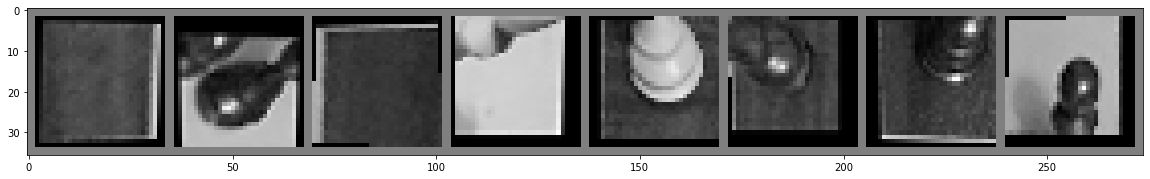

Loading in pretrained network ...
Number of inputs to final fully connected layer: 512
Trainable model parameters:
Tensor  torch.Size([2, 512])  number of params:  1024
Tensor  torch.Size([2])  number of params:  2
Total number of trainable parameters: 1026
Quick test to verify output size: should be [2, 2]:
torch.Size([2, 2])
Training the network ...
Epoch:  0
Iteration 0, loss = 0.9296
Got 20 / 30 correct (0.666667) on validation

Epoch:  1
Iteration 0, loss = 0.7963
Got 18 / 30 correct (0.600000) on validation

Epoch:  2
Iteration 0, loss = 0.8549
Got 14 / 30 correct (0.466667) on validation

Epoch:  3
Iteration 0, loss = 0.3527
Got 24 / 30 correct (0.800000) on validation

Epoch:  4
Iteration 0, loss = 0.6195
Got 21 / 30 correct (0.700000) on validation

Epoch:  5
Iteration 0, loss = 0.2909
Got 22 / 30 correct (0.733333) on validation

Epoch:  6
Iteration 0, loss = 0.4163
Got 21 / 30 correct (0.700000) on validation

Epoch:  7
Iteration 0, loss = 0.5938
Got 21 / 30 correct (0.70000

Got 25 / 30 correct (0.833333) on validation

Epoch:  94
Iteration 0, loss = 0.1679
Got 25 / 30 correct (0.833333) on validation

Epoch:  95
Iteration 0, loss = 0.3422
Got 29 / 30 correct (0.966667) on validation

Epoch:  96
Iteration 0, loss = 0.0748
Got 28 / 30 correct (0.933333) on validation

Epoch:  97
Iteration 0, loss = 0.2304
Got 26 / 30 correct (0.866667) on validation

Epoch:  98
Iteration 0, loss = 0.2683
Got 27 / 30 correct (0.900000) on validation

Epoch:  99
Iteration 0, loss = 0.1277
Got 26 / 30 correct (0.866667) on validation

Epoch:  100
Iteration 0, loss = 0.3552
Got 27 / 30 correct (0.900000) on validation

Epoch:  101
Iteration 0, loss = 0.1889
Got 27 / 30 correct (0.900000) on validation

Epoch:  102
Iteration 0, loss = 0.1578
Got 29 / 30 correct (0.966667) on validation

Epoch:  103
Iteration 0, loss = 0.4024
Got 27 / 30 correct (0.900000) on validation

Epoch:  104
Iteration 0, loss = 0.1441
Got 28 / 30 correct (0.933333) on validation

Epoch:  105
Iteration 0, 

Epoch:  190
Iteration 0, loss = 0.5008
Got 29 / 30 correct (0.966667) on validation

Epoch:  191
Iteration 0, loss = 0.1083
Got 28 / 30 correct (0.933333) on validation

Epoch:  192
Iteration 0, loss = 0.1106
Got 27 / 30 correct (0.900000) on validation

Epoch:  193
Iteration 0, loss = 0.2423
Got 29 / 30 correct (0.966667) on validation

Epoch:  194
Iteration 0, loss = 0.1774
Got 29 / 30 correct (0.966667) on validation

Epoch:  195
Iteration 0, loss = 0.4103
Got 27 / 30 correct (0.900000) on validation

Epoch:  196
Iteration 0, loss = 0.1500
Got 27 / 30 correct (0.900000) on validation

Epoch:  197
Iteration 0, loss = 0.3291
Got 29 / 30 correct (0.966667) on validation

Epoch:  198
Iteration 0, loss = 0.3180
Got 28 / 30 correct (0.933333) on validation

Epoch:  199
Iteration 0, loss = 0.1433
Got 27 / 30 correct (0.900000) on validation

Total training time: 1173.571436 seconds
Evaluating accuracy on test set ...
Confusion matrix (rows=true, cols=predicted):
[[ 22   8]
 [ 12 108]]
Accu

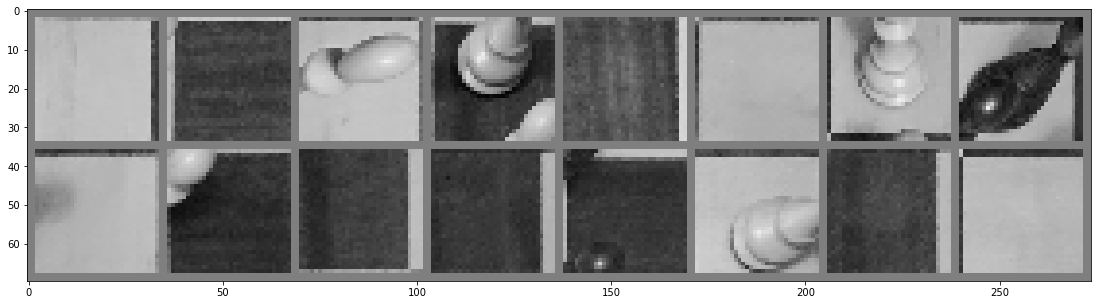

Saving modle to ../data/models/iter_0.pt
All done!


In [12]:
if __name__ == "__main__":
    main()

In [13]:
model_1 = Net()
model_1.load_state_dict(torch.load(str(save_path+model_name)))
model_1.eval()

Loading in pretrained network ...
Number of inputs to final fully connected layer: 512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

train_loader, val_loader, test_loader = load_data()
# Test the network.
print('Evaluating accuracy on test set ...')
eval_test_accuracy(test_loader, model_1)

# Show some example classifications.
print("Results on example test images:")
show_example_results(test_loader, model_1)

In [15]:
model_1.to(device)
# Run some random data through the network to check the output size.
x = torch.zeros((2, 3, 32, 32)).to(device)  # minibatch size 2, image size [3, 32, 32]
scores = model_1(x)

In [16]:
scores

tensor([[-4.6051, -5.1307],
        [-4.6051, -5.1307]], device='cuda:0', grad_fn=<AddmmBackward>)